In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# NOTICE: HERE YOU NEED TO CHANGE THE  '../frame_data' to the place you put the .tfrecord file.
from subprocess import check_output
print(check_output(["ls", "../frame_data"]).decode("utf8"))


1,10000_frame_level_train_download_plan.json
1,1000_frame_level_train_download_plan.json
1_frame_level_train_download_plan.json
train0_.tfrecord
train45.tfrecord
train6l.tfrecord
train8D.tfrecord
trainbX.tfrecord
trainDh.tfrecord
trainEe.tfrecord
trainHA.tfrecord
trainjw.tfrecord
trainkV.tfrecord
trainr4.tfrecord
trainR4.tfrecord
trainUS.tfrecord
trainUY.tfrecord
trainVK.tfrecord
trainWK.tfrecord



In [4]:
import tensorflow as tf
from IPython.display import YouTubeVideo

# NOTICE: HERE YOU NEED TO CHANGE THE two paths to the place you put the .tfrecord file.
video_lvl_record = "../features/train0_.tfrecord"
frame_lvl_record = "../frame_data/train0_.tfrecord"

In [3]:
print video_lvl_record


../features/train0_.tfrecord


In [4]:
vid_ids = []
labels = []
mean_rgb = []
mean_audio = []

for example in tf.python_io.tf_record_iterator(video_lvl_record):
    tf_example = tf.train.Example.FromString(example)

    vid_ids.append(tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)
    mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
    mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)

In [5]:
print('Number of videos in this tfrecord: ',len(mean_rgb))
print('First video feature length',len(mean_rgb[0]))
print('First 20 features of the first youtube video (',vid_ids[0],')')
print(mean_rgb[0][:20])

('Number of videos in this tfrecord: ', 1230)
('First video feature length', 1024)
('First 20 features of the first youtube video (', u'0_eSi7CwB-4', ')')
[-0.7036563754081726, 0.38342997431755066, 1.7236982583999634, 0.48541828989982605, 0.9511630535125732, -0.09970728307962418, 0.19943273067474365, -0.258606493473053, -0.45884039998054504, -0.9229339957237244, 0.18374645709991455, 0.002391103422269225, -0.8100478649139404, -0.08281013369560242, -0.17648746073246002, -0.20593363046646118, 0.7639734745025635, -0.5236769914627075, 0.843615710735321, 0.022755740210413933]


In [9]:
def play_one_vid(record_name, video_index):
    return vid_ids[video_index]
    
# this worked on my local jupyter notebook, but doesn't show on kaggle kernels:
YouTubeVideo(play_one_vid(video_lvl_record, 7))

In [29]:
# now, let's read the frame-level data

feat_rgb = []
feat_audio = []


for example in tf.python_io.tf_record_iterator(frame_lvl_record):        
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    # print tf_seq_example
   
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # find the vid of the video
    seq_vid = tf_seq_example.context.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8')
    # print tf_seq_example
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
       
         """
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
                                              
        """
        
        
    sess.close()
    feat_rgb.append(rgb_frame)
    feat_audio.append(audio_frame)
    break



In [43]:

feat_rgb = []
feat_audio = []
from time import time

def test():
    for example in tf.python_io.tf_record_iterator(frame_lvl_record):        
        tf_seq_example = tf.train.SequenceExample.FromString(example)
        n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
        tf_feat_list = tf_seq_example.feature_lists.feature_list['rgb']
        # print tf_seq_example

        rgb_frame = tf.Variable(tf.zeros([n_frame, 1024]))

        for i in range(n_frames):
            rgb_frame = tf.scatter_update(rgb_frame, tf.constant(i, dtype=tf.int32),tf.cast(tf.decode_raw(
                        tf_feat_list.feature[i].bytes_list.value[0],tf.uint8),tf.float32))
        with tf.Session() as sess:
            tf.global_variables_initializer().run()
            rgb_frame_py = sess.run([rgb_frame])

        break

st = time()
test()
print("%.2f"%(time()-st))

6.11


In [33]:
rgb_frame[0]

<tf.Tensor 'DecodeRaw_2634:0' shape=(?,) dtype=uint8>

In [27]:
print('The first video has %d frames' %len(feat_rgb[0]))
n_frame = len(feat_rgb[0])
print seq_vid

The first video has 285 frames
0_eSi7CwB-4


In [53]:
YouTubeVideo(seq_vid)

In [5]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [20]:
y = 0;
for x in rgb_frame:
    if y == 0:
        print x
        y+=1
print rgb_frame[0]

[   0.   79.  167. ...,  131.  126.  128.]
[   0.   79.  167. ...,  131.  126.  128.]


In [21]:
# Reshape the frame feature
X = np.zeros([n_frame, 1024])
for i in xrange(n_frame):
    X[i,:] = feat_rgb[0][i]


In [22]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

In [23]:
kmeans.labels_

array([6, 6, 6, 6, 6, 9, 0, 6, 5, 2, 2, 6, 6, 2, 2, 2, 3, 3, 2, 2, 2, 5, 5,
       2, 4, 7, 7, 7, 5, 0, 0, 0, 0, 5, 2, 4, 7, 7, 7, 1, 1, 1, 1, 7, 7, 3,
       3, 8, 6, 3, 8, 6, 3, 4, 8, 6, 8, 4, 4, 4, 1, 8, 1, 1, 3, 3, 1, 5, 4,
       4, 4, 5, 5, 6, 5, 6, 3, 4, 5, 4, 8, 4, 4, 6, 1, 6, 4, 3, 3, 3, 5, 5,
       5, 5, 5, 3, 5, 5, 5, 8, 4, 5, 6, 4, 6, 5, 9, 5, 9, 6, 3, 6, 6, 6, 6,
       1, 6, 4, 4, 4, 4, 5, 5, 5, 4, 5, 6, 6, 5, 3, 5, 5, 3, 5, 3, 6, 6, 6,
       6, 6, 5, 6, 4, 6, 4, 4, 4, 6, 6, 6, 6, 6, 6, 4, 4, 0, 0, 6, 4, 4, 0,
       6, 4, 4, 9, 9, 4, 9, 2, 6, 6, 9, 2, 6, 2, 2, 6, 6, 6, 6, 6, 2, 6, 2,
       1, 1, 1, 1, 1, 1, 6, 9, 6, 1, 1, 2, 2, 8, 2, 2, 8, 2, 6, 2, 8, 8, 2,
       2, 2, 8, 4, 4, 2, 9, 9, 0, 5, 9, 9, 6, 6, 5, 4, 6, 6, 6, 6, 5, 6, 4,
       9, 6, 5, 9, 9, 9, 4, 9, 4, 9, 6, 6, 9, 9, 9, 2, 9, 6, 2, 2, 2, 2, 6,
       9, 9, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 6, 6, 6, 6], dtype=int32)

In [41]:
# Try gassuian mix
from sklearn import mixture


In [69]:
clf = mixture.GaussianMixture(n_components=10, covariance_type='full', max_iter=500, init_params='kmeans')
clf.fit(X)
clf_lables = clf.predict(X)
print clf_lables

[6 6 6 0 6 5 5 5 5 2 2 6 6 2 2 2 7 3 2 2 2 4 4 2 2 3 3 3 5 5 5 5 5 5 2 2 3
 3 3 9 9 9 9 3 3 7 7 7 4 7 7 6 7 2 6 4 7 2 2 2 9 7 9 9 7 7 9 6 2 2 2 6 4 6
 1 4 7 2 4 2 7 2 2 6 6 4 2 7 7 7 4 4 4 4 4 7 4 5 5 7 2 4 6 2 6 5 5 5 5 6 7
 6 4 4 4 6 6 2 2 2 2 4 4 4 8 5 6 6 4 7 4 4 7 4 7 4 4 1 1 6 4 4 8 4 8 8 8 4
 4 4 6 6 1 8 8 5 5 6 8 8 5 4 8 8 5 5 8 5 2 4 4 5 2 6 2 2 6 6 6 6 6 2 6 2 9
 9 9 9 9 9 6 6 6 9 9 2 2 7 2 2 6 2 6 2 6 6 2 2 2 7 2 2 2 5 5 5 5 5 5 4 4 5
 8 4 4 4 6 4 1 8 5 1 4 5 5 5 8 5 2 5 6 6 5 5 5 2 5 6 2 2 2 2 6 5 5 2 2 2 2
 2 2 2 2 6 6 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 0 0 0]


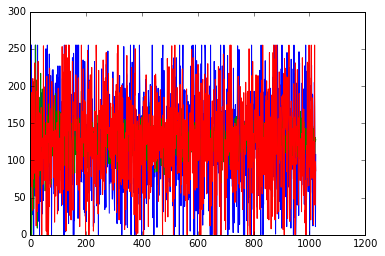

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(X[20,:])
plt.plot(X[0,:])
plt.plot(X[3,:])

plt.show()

In [82]:
# TRY cos similarity to compute the difference betwe two consequce video frame.
def cosSimlarity(a, b):
    c = sum(a*b)
    return c / sum(a*a)**0.5 / sum(b*b)**0.5


[0.87162576973759454, 0.78663328965269519, 0.80441022632737524, 0.79239312014365659, 0.80131192450552868, 0.87142020140868093, 0.88506809738907588, 0.89193966726366769, 0.84221580737572199, 0.97474288803490894, 0.79142810666082408, 0.87702427204429567, 0.79797986627497286, 0.98960316774446644, 0.98699506670157722, 0.83092680309629918, 0.92310034790051965, 0.83383931315728321, 0.98817616699786026, 0.97504740746413343, 0.8092345575854295, 0.89017134121026065, 0.85984812953614242, 0.98357614168015695, 0.82191221342281828, 0.93756555609939829, 0.9483913889152068, 0.83205482729834912, 0.91752240511814631, 0.90411848988124832, 0.88727372190582954, 0.92866333730514239, 0.90057419492190793, 0.83259249459847495, 0.98113532372167322, 0.82693306608697947, 0.95358895842479585, 0.94461811187620692, 0.81278753200893172, 0.9399777262133493, 0.94472329139858413, 0.92536848114733383, 0.80085664501006171, 0.94446369326850044, 0.84939757530882132, 0.92304920264407964, 0.85706361525231634, 0.8026610915358

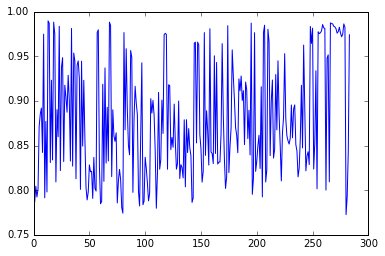

In [85]:
cos_1 = []
abrupt_frame_index = []
threshold = 0.8
for i in xrange(n_frame-1):
    cos = cosSimlarity(X[i,:], X[i+1,:])
    cos_1.append(cos)
    if cos < threshold:
        abrupt_frame_index.append(i)
plt.plot(cos_1)
print cos_1
print abrupt_frame_index

In [15]:
def GetFrameId(rgb_frame, num_classes = 10):
    """
    input arg: rgb_frame: the list of 1D array of the rgb frame features
    return a 1D array with id of each extracted features.
    This function need to from sklearn.cluster import KMeans. 
    """
    # convert the rgb_frame data to 2D array
    n_frame = len(rgb_frame)
    n_dim = len(rgb_frame[0])
    X = np.zeros([n_frame, n_dim])
    for i in xrange(n_frame):
        X[i,:] = rgb_frame[i]
    kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(X)
    # here just obtain the frame by order (i.e. if the kmeans results is 3412333344, we will return
    # 0, 1, 2, 3 )
    res = []
    read_dict = []
    for i in xrange(len(kmeans.labels_)):
        label = kmeans.labels_[i]
        if label not in read_dict:
            res.append(i)
            read_dict.append(label)
            if len(res) == num_classes:
                return res
    
def CopyByFrameId(frame_feature_file_path, frame_feature_des_path, n_max_write = 2):
    """
    frame_feature_file_path: a string represents the path to a file which stores the frame level features.
    return bool which represents storage is successful or not.
    """
    n_read_file = 0
    writer = tf.python_io.TFRecordWriter(frame_feature_des_path)
    for example in tf.python_io.tf_record_iterator(frame_feature_file_path):        
        tf_seq_example = tf.train.SequenceExample.FromString(example)
        sess = tf.InteractiveSession()
        rgb_frame = []
        n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
        # find the vid of the video
        # iterate through frames
        for i in range(n_frames):
            rgb_frame.append(tf.cast(tf.decode_raw(
                    tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                           ,tf.float32).eval())

        sess.close()        
        extracted_id = GetFrameId(rgb_frame, 2)   
        new_frame_data = tf.train.SequenceExample()
        new_frame_data.context.CopyFrom(tf_seq_example.context)
        # iterate through frames
        for i in extracted_id:
            new_frame_data.feature_lists.feature_list['rgb'].feature.extend(
                [tf_seq_example.feature_lists.feature_list['rgb'].feature[i]])
        
        # Write to the des.
        writer.write(new_frame_data.SerializeToString())
        if (n_max_write > 0):
            n_read_file += 1
            if (n_read_file >= n_max_write):
                break
    writer.close()

In [48]:
frame_lvl_record

'../frame_data/train0_.tfrecord'

In [16]:
fram_des = '../frame_changed_data/train0_.tfrecord'
CopyByFrameId(frame_lvl_record, fram_des, 2)

In [17]:
# Test to read the changed file.
for example in tf.python_io.tf_record_iterator(fram_des): 
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    print tf_seq_example
    

context {
  feature {
    key: "labels"
    value {
      int64_list {
        value: 16
        value: 9
        value: 3
        value: 7
      }
    }
  }
  feature {
    key: "video_id"
    value {
      bytes_list {
        value: "0_eSi7CwB-4"
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "rgb"
    value {
      feature {
        bytes_list {
          value: "\000O\247+\000\000/!\310\205\316V#\237\223\320?\222L\377Z\320\264\211\210\t\272\216.wp\271|O\204\\t\331h>\211\222\214\304|z\246\227\271r\275\220\223;Kv\227o\210pVo\240[lb\260\232ed\224zg{rD\253\214s\221j\203\255\203_s\263\213_q\276Ju\244\210o\247\201T\225\226~\241\231\217\246\213W\244\242\203\217\177\205\222o\177ku\247q]\235\204\200\210\214\222\221t\253\207\264juZg\260\233\223\217hup\210\223\226S_Qc\204\230{`\177\234\207fS~\204\200l\240\201\206ak\213\234ad\205\230\235\232eg\201bl\236\301\206s\217\211\215txix\210~t\253ipxun\204\221Zy\221\230Nw\210\233\215\203s\215|\202\201q\211n\210\227q~\215\200\207m\247\217